## Imports

In [1]:
seed = 17
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
import pickle

# Main Random Forest

## Load Data

In [2]:
# LOAD DATA
# Lists of observations and targets
Xs = []
ys = []

Xs.append(pd.read_csv("../data/credit_X.csv"))
Xs.append(pd.read_csv("../data/raisin_X.csv"))
Xs.append(pd.read_csv("../data/alzheimer_X.csv"))
Xs.append(pd.read_csv("../data/salary_X.csv"))

ys.append(pd.read_csv("../data/credit_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/raisin_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/alzheimer_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/salary_y.csv").iloc[:, 0])

## Functions

In [11]:
def tune_with_random_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        # in my case works faster with n_jobs=-1
        opt = RandomizedSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed, n_jobs=-1)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results
    
def tune_with_bayes_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        opt = BayesSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def get_tunability(model_class, default_grid, tuned_grids, scoring):
    tunabilities = []
    for i in range(4):
        # Replace key "model__hiperparameter" to key "hiperparameter"
        cleaned_params = {key.replace('model__', ''): value for key, value in tuned_grids[i].best_params_.items()}
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        pipe_tuned = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**cleaned_params))            
        ])
        
        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tuned_score = cross_val_score(pipe_tuned, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tunabilities.append(tuned_score - default_score)
    return tunabilities

def save_result(result, path_to_save):
    with open(path_to_save, 'wb') as file:
        pickle.dump(result, file)

def load_result(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

def get_deafult_score(model_class, default_grid, scoring):
    default_scores = []
    for i in range(4):
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        default_scores.append(default_score)
    return default_scores

## Algorithm tunability

### RandomSearch

In [4]:
# Using an article
search_grid = {
    'model__n_estimators': np.arange(200, 1750, 25),                      
    'model__max_depth': [None] + list(np.arange(5, 110, 5)),          
    'model__min_samples_split': np.arange(2, 20, 2),                    
    'model__min_samples_leaf': np.arange(1, 20, 2),                     
    'model__max_features': ['sqrt', 'log2', None],                                
    'model__criterion': ['gini', 'entropy', 'log_loss'],                
    'model__max_samples': [None] + list(np.linspace(0.1, 1.0, 10)),
    'model__random_state': [seed],
    'model__n_jobs': [-1],
    'model__ccp_alpha': stats.loguniform(1e-4, 1e4)
}

In [5]:
pipe = Pipeline(steps=[
    ('preprocessing', MinMaxScaler()),
    ('model', RandomForestClassifier())
])

In [6]:
%%time
# Tuning using randomsearch
rf_opt_results_rs = tune_with_random_search(pipe, search_grid, 100, "roc_auc")

CPU times: total: 45.5 s
Wall time: 18min 13s


In [7]:
# Save tuning
save_result(rf_opt_results_rs, "./saved_results/rf_opt_results_rs.pkl")

In [8]:
# Best params and scores:
for i in range(4):
    print(rf_opt_results_rs[i].best_params_)
    print(rf_opt_results_rs[i].best_score_)

{'model__ccp_alpha': 0.03938489506695156, 'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': None, 'model__max_samples': 0.7000000000000001, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 400, 'model__n_jobs': -1, 'model__random_state': 17}
0.6779155785734733
{'model__ccp_alpha': 0.0004640910627339455, 'model__criterion': 'entropy', 'model__max_depth': 100, 'model__max_features': None, 'model__max_samples': 0.4, 'model__min_samples_leaf': 7, 'model__min_samples_split': 14, 'model__n_estimators': 250, 'model__n_jobs': -1, 'model__random_state': 17}
0.9289506172839506
{'model__ccp_alpha': 0.001166783933518692, 'model__criterion': 'log_loss', 'model__max_depth': 50, 'model__max_features': None, 'model__max_samples': 0.5, 'model__min_samples_leaf': 9, 'model__min_samples_split': 4, 'model__n_estimators': 525, 'model__n_jobs': -1, 'model__random_state': 17}
0.9523147888681265
{'model__ccp_alpha': 0.00033724097389280184, 'model_

In [8]:
rf_tunabilities_rs = get_tunability(RandomForestClassifier, {'random_state': seed, 'n_jobs': -1}, rf_opt_results_rs, "roc_auc")
rf_tunabilities_rs

[0.0663883859196358,
 0.005283950617283706,
 0.004466987876542872,
 0.003323216212659741]

### BayesSearch

In [10]:
# Using an article
search_grid = {
    'model__n_estimators': Integer(200, 1750),                       
    'model__max_depth': Integer(5, 200), 
    'model__min_samples_split': Integer(2, 20),                      
    'model__min_samples_leaf': Integer(1, 20),                       
    'model__max_features': Categorical(['sqrt', 'log2', None]),      
    'model__criterion': Categorical(['gini', 'entropy', 'log_loss']), 
    'model__max_samples': Real(0.1, 1.0),
    'model__random_state': Categorical([seed]),                     
    'model__n_jobs': Categorical([-1]),                             
    'model__ccp_alpha': Real(1e-4, 1e4, prior='log-uniform') 
} 

In [11]:
pipe = Pipeline(steps=[
    ('preprocessing', MinMaxScaler()),
    ('model', RandomForestClassifier())
])

In [12]:
%%time
# Tuning using bayessearch
rf_opt_results_bs = tune_with_bayes_search(pipe, search_grid, 100, "roc_auc")

CPU times: total: 4h 13min 38s
Wall time: 2h 18min 20s


In [13]:
save_result(rf_opt_results_bs, "./saved_results/rf_opt_results_bs.pkl")

In [14]:
for i in range(4):
    print(rf_opt_results_bs[i].best_params_)
    print(rf_opt_results_bs[i].best_score_)

OrderedDict({'model__ccp_alpha': 0.02493723086425569, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': None, 'model__max_samples': 1.0, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 200, 'model__n_jobs': -1, 'model__random_state': 17})
0.6835930425568584
OrderedDict({'model__ccp_alpha': 0.004608232954439042, 'model__criterion': 'entropy', 'model__max_depth': 200, 'model__max_features': None, 'model__max_samples': 0.4516760937270061, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 1746, 'model__n_jobs': -1, 'model__random_state': 17})
0.9301728395061728
OrderedDict({'model__ccp_alpha': 0.0008316787187961211, 'model__criterion': 'log_loss', 'model__max_depth': 200, 'model__max_features': None, 'model__max_samples': 0.313237476361665, 'model__min_samples_leaf': 1, 'model__min_samples_split': 20, 'model__n_estimators': 1750, 'model__n_jobs': -1, 'model__random_state': 17})
0.9529047634018948


In [15]:
rf_tunabilities_bs = get_tunability(RandomForestClassifier, {'random_state': seed, 'n_jobs': -1}, rf_opt_results_bs, "roc_auc")
rf_tunabilities_bs

[0.0720658499030209,
 0.0065061728395059415,
 0.005056962410311172,
 0.007107366758784206]

### Plots

In [6]:
rf_opt_results_rs = load_result("./saved_results/rf_opt_results_rs.pkl")
rf_opt_results_bs = load_result("./saved_results/rf_opt_results_bs.pkl")

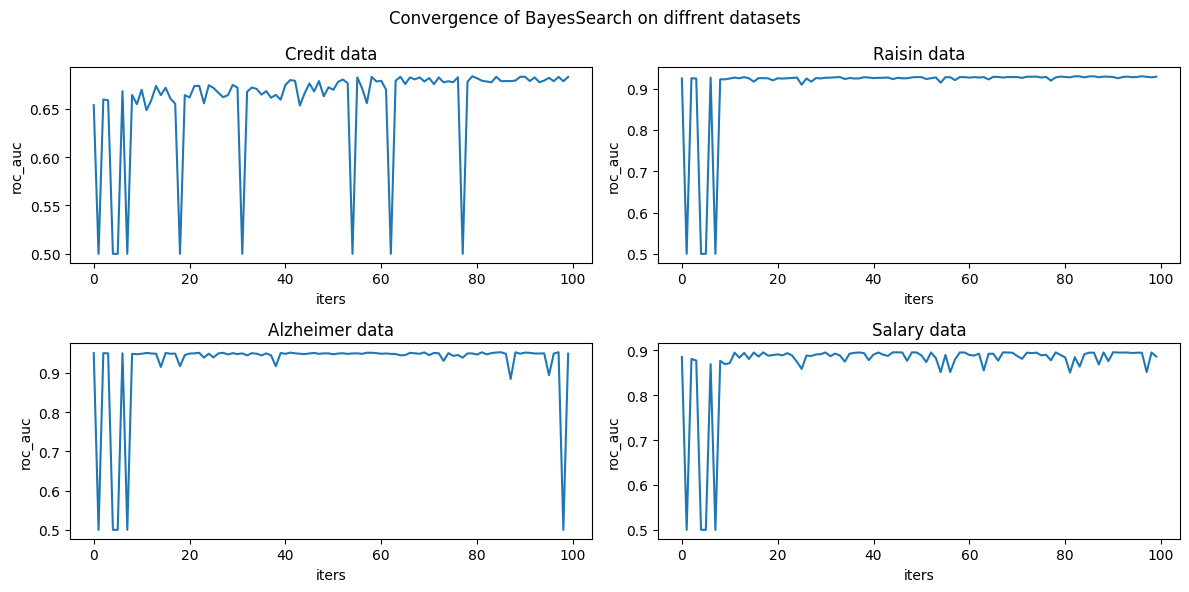

In [7]:
titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
axs = axs.flatten()
fig.suptitle("Convergence of BayesSearch on diffrent datasets")
for i in range(4):
    axs[i].plot(rf_opt_results_bs[i].cv_results_["mean_test_score"])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("iters")
    axs[i].set_ylabel("roc_auc")
plt.tight_layout()
plt.show()

In [9]:
rf_tunabilities_rs = get_tunability(RandomForestClassifier, {'random_state': seed, 'n_jobs': -1}, rf_opt_results_rs, "roc_auc")
rf_tunabilities_bs = get_tunability(RandomForestClassifier, {'random_state': seed, 'n_jobs': -1}, rf_opt_results_bs, "roc_auc")

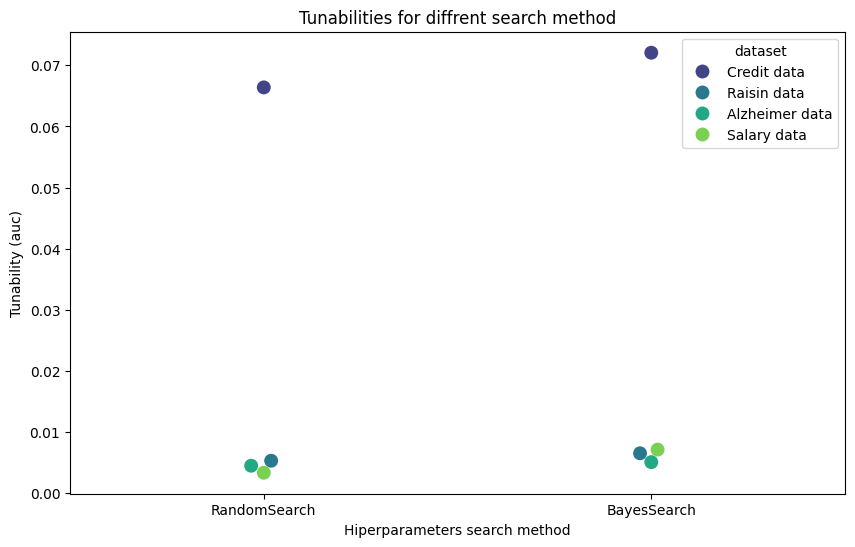

In [10]:
data = {
    'tunability': rf_tunabilities_rs + rf_tunabilities_bs,
    'alg': ["RandomSearch"] *  4 + ["BayesSearch"] * 4,
    'dataset': ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]*2
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.swarmplot(x='alg', y='tunability', hue='dataset', data=df, palette='viridis', size=10)

plt.title('Tunabilities for diffrent search method')
plt.xlabel('Hiperparameters search method')
plt.ylabel('Tunability (auc)')
plt.show()

### Histogram of metric value differences

In [12]:
default_score = get_deafult_score(RandomForestClassifier, {'random_state': seed, "n_jobs": -1}, 'roc_auc')
default_score

[0.6115271926538375,
 0.9236666666666669,
 0.9478478009915836,
 0.8886013843926832]

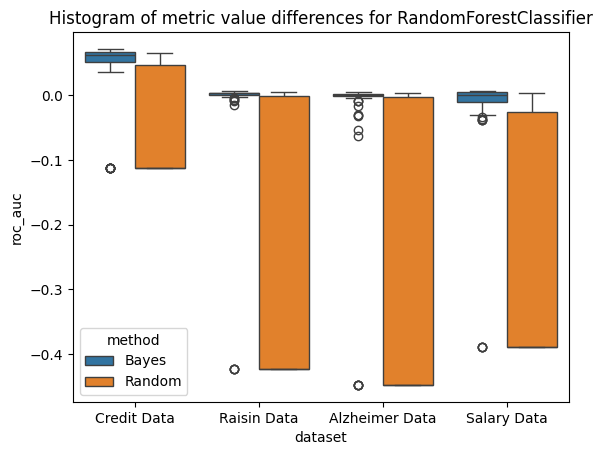

In [13]:
data = {
    'Credit Data': rf_opt_results_bs[0].cv_results_["mean_test_score"]-default_score[0],
    'Raisin Data': rf_opt_results_bs[1].cv_results_["mean_test_score"]-default_score[1],
    'Alzheimer Data': rf_opt_results_bs[2].cv_results_["mean_test_score"]-default_score[2],
    'Salary Data': rf_opt_results_bs[3].cv_results_["mean_test_score"]-default_score[3]
}
data_random = {
    'Credit Data': rf_opt_results_rs[0].cv_results_["mean_test_score"]-default_score[0],
    'Raisin Data': rf_opt_results_rs[1].cv_results_["mean_test_score"]-default_score[1],
    'Alzheimer Data': rf_opt_results_rs[2].cv_results_["mean_test_score"]-default_score[2],
    'Salary Data': rf_opt_results_rs[3].cv_results_["mean_test_score"]-default_score[3]
} 
data = pd.DataFrame(data)
data_random = pd.DataFrame(data_random)
# connect datasets data and data_random, adding column with method Random and Bayes 
data['method'] = 'Bayes'
data_random['method'] = 'Random'
data = pd.concat([data, data_random])
data = data.melt(id_vars='method', var_name='dataset', value_name='roc_auc')

sns.boxplot(x='dataset', y='roc_auc', hue='method', data=data)
plt.title('Histogram of metric value differences for RandomForestClassifier')
plt.show()